# Exploring Hoffman Stochastic VI

In [16]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [17]:
#np.random.seed(43141) 
np.random.seed(234213)

Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP

alpha = 10 # IBP parameter

# Parameters to draw A from MVN
sigma_eps = .1 # variance of noise
sigma_A = 100

# generate data
Pi, Z, mu, A, X = generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)



# Set initializations 

In [18]:
# set initializations
K_approx = deepcopy(K_inf) # variational truncation
tau, nu, phi_mu, phi_var = initialize_parameters(Num_samples, D, K_approx)

Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}

"""print(X[0:10,:])
print(tau)
print(phi_mu)
print(nu[0:10,:])
"""

'print(X[0:10,:])\nprint(tau)\nprint(phi_mu)\nprint(nu[0:10,:])\n'

# run stochastic VI

In [19]:
iter_ran = 0

In [20]:
iterations = 1000
elbo = np.zeros(iterations)

batch_size = 10
assert batch_size % 1 == 0  # make sure this is an integer
batch_size = int(batch_size)

for i in range(iterations): 
    # sample data
    indices = np.random.choice(Num_samples, size = batch_size, replace = False)
    

    # update local parameters: in this case, nu
    digamma_tau = sp.special.digamma(tau)
    for n in indices: 
        for k in range(K_approx): 
            nu_updates(tau, nu, phi_mu, phi_var, X, sigmas, n, k, digamma_tau)

    # replicate data
    replicates = Num_samples/batch_size 
    # the method below will only work when Num_samples is a multiple of batch_size
    assert Num_samples%batch_size == 0 
    
    replicates = int(replicates)
    
    nu_stochastic = np.zeros((Num_samples, K_approx))
    X_stochastic = np.zeros((Num_samples, D))
    for j in range(batch_size): 
        nu_stochastic[j*replicates:(j+1)*replicates , :] = nu[indices[j], :]
        X_stochastic[j*replicates:(j+1)*replicates , :] = X[indices[j], :]
    
    """ print(nu[indices, :])
        print(X[indices, :])
        print(nu_stochastic)
        print(X_stochastic)
    """ 
        
    # update global paremeters: phi_mu, phi_var, and tau
    
    step_size = (iter_ran+1)**(-0.9)
    
    for k in range(K_approx): 
        phi_mu_old = deepcopy(phi_mu)
        phi_var_old = deepcopy(phi_var)

        phi_updates(nu_stochastic, phi_mu, phi_var, X_stochastic, sigmas, k)
        
        phi_mu = phi_mu_old * (1-step_size) + phi_mu * step_size
        phi_var = phi_var_old * (1-step_size) + phi_var * step_size
        
    for k in range(K_approx): 
        tau_old = deepcopy(tau)
        tau_updates(tau, nu_stochastic, alpha)
        tau = tau_old * (1-step_size) + tau * step_size
            
    iter_ran = iter_ran + 1
    
    elbo[i] = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)

    print('iteration: ', i, ' l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]), 'elbo: ', elbo[i])
    
    #if np.abs(elbo[i]-elbo[i-1]) <= 10**(-8) and np.abs(elbo[i-1]-elbo[i-2]) <= 10**(-8):
    #    print('ELBO converged')
    #    break

iteration:  0  l1 error:  0.489847047372 elbo:  -57056.6490249
iteration:  1  l1 error:  0.49172173704 elbo:  -32091.3093375
iteration:  2  l1 error:  0.493073423415 elbo:  -9691.9888293
iteration:  3  l1 error:  0.49418048462 elbo:  7825.87784507
iteration:  4  l1 error:  0.493711787909 elbo:  23166.8981057
iteration:  5  l1 error:  0.492143236764 elbo:  36025.2276205
iteration:  6  l1 error:  0.491496479082 elbo:  51035.3078484
iteration:  7  l1 error:  0.496174422387 elbo:  70155.5132788
iteration:  8  l1 error:  0.497291934243 elbo:  84459.0453695
iteration:  9  l1 error:  0.501308379128 elbo:  96044.3914721
iteration:  10  l1 error:  0.503905836674 elbo:  117320.06352
iteration:  11  l1 error:  0.505283745576 elbo:  129533.294539
iteration:  12  l1 error:  0.506912686077 elbo:  150305.797276
iteration:  13  l1 error:  0.509657323236 elbo:  168742.053226
iteration:  14  l1 error:  0.508912917913 elbo:  177175.175521
iteration:  15  l1 error:  0.510792502952 elbo:  192369.9133
itera

Z (unpermuted): 
 [[1 1 1]
 [1 1 1]
 [1 1 0]
 [0 1 0]
 [1 1 1]
 [0 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]
** procedure did not give a true permutation
permutation:  [2, 0, 1]
Z (permuted) 
 [[1 1 1]
 [1 1 1]
 [0 1 1]
 [0 0 1]
 [1 1 1]
 [1 0 1]
 [1 0 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]
round_nu 
 [[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]
l1 error (after permutation):  [0.19999999998911314, 0.85399999999999998, 0.82799999999999996]


true A (permuted): 
 [[  2.67705195   0.75207494]
 [ -4.56292503 -16.4070799 ]
 [ 14.39945263  -2.48764823]]
phi_mu: 
 [[  1.03864978e+01  -1.57733657e+01]
 [  7.58610070e-31   2.56181260e-30]
 [  2.65045836e-11   8.95055034e-11]]


true Pi (permuted):  [ 0.8  0.8  0.8]
computed Pi:  [ 0.97259676  0.00660939  0.00660939]


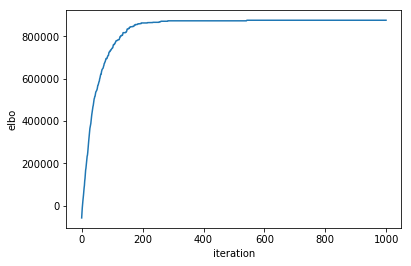

In [21]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [2,0,1]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

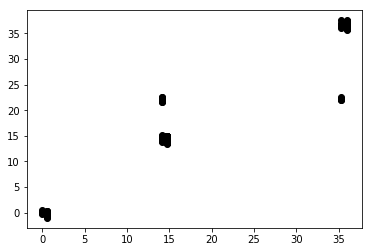

In [93]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 0
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')
plt.show()

    phi_mu_old = deepcopy(phi_mu)
    phi_var_old = deepcopy(phi_var)
    tau_old = deepcopy(tau)

    # compute step-size
    """if step_size < 10**(-4): 
        step_size = 10**(-1)
    else: 
        step_size = 1/(1/step_size+1)
    """
    step_size = (iter_ran+1)**(-0.6)
    #step_size = 1
    
    # update global parameters
    phi_mu = phi_mu_old * (1-step_size) + phi_mu * step_size
    phi_var = phi_var_old * (1-step_size) + phi_var * step_size
    tau = tau_old * (1-step_size) + tau * step_size
